In [1]:
# Dependency for bert inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 4.3MB/s 


In [2]:
# For using adam optimizer from tensor flow models
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 5.8MB/s 
     |████████████████████████████████| 645kB 37.2MB/s 
     |████████████████████████████████| 174kB 49.0MB/s 
     |████████████████████████████████| 358kB 21.6MB/s 
     |████████████████████████████████| 1.2MB 38.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 37.6MB 112kB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 706kB 54.7MB/s 


In [14]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , plot_roc_curve

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

#tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Capstone/Data/

train = pd.read_csv("train_clean_lemmatize.csv")

/content/drive/My Drive/Capstone/Data


In [6]:
train.shape

(1778628, 35)

In [7]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,comment_cleaned,comment_lemmatized,target_label
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is so cool it like would you want your mo...,cool like would want mother read realli great ...,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,thank you this would make my life lot less anx...,thank would make life lot less anxieti induc k...,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is such an urgent design problem kudos to...,urgent design problem kudo take impress,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,is this something ll be able to install on my ...,someth abl instal site releas,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,haha you guys are bunch of losers,haha guy bunch loser,1


In [8]:
X = train['comment_cleaned']
y = train['target_label']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state=42)

In [9]:
y_train.value_counts(normalize=True)

0    0.919919
1    0.080081
Name: target_label, dtype: float64

In [10]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1333971,) (1333971,) (444657,) (444657,)


In [11]:
bert_model_handler = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_preprocessor = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [20]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), 
                                       dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(bert_preprocessor, 
                                         name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_handler, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, 
                                activation='sigmoid', 
                                name='classifier')(net)

    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = [tf.metrics.BinaryAccuracy('accuracy'), tf.metrics.Recall()]
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    
    epochs = 15
    steps_per_epoch = int(X_train.shape[0] / 32)
    num_train_steps = steps_per_epoch * epochs
    num_warm_steps = int(0.1 * num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=1e-5,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warm_steps)

    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metric)
    return model

In [21]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

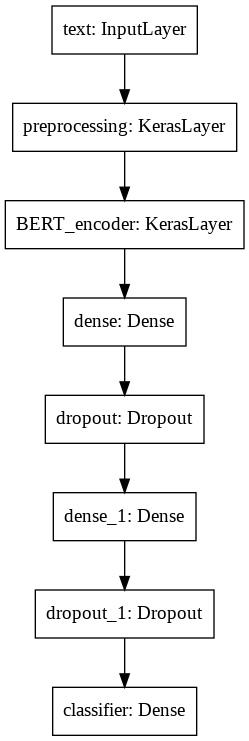

In [14]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.predict(['I am a happy women', 'This is a sad women', 'This is an idiotic asshole'])

array([[0.69099534],
       [0.6246667 ],
       [0.73026973]], dtype=float32)

In [22]:
checkpoint_path = '/content/drive/My Drive/Capstone/Code/BaseModels/BertFull_0'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1)

history = classifier_model.fit(x=X_train.values,
                               y=y_train.values,
                               validation_data=(X_val.values, y_val.values),
                               epochs=1,
                               batch_size=32,
                               callbacks=[checkpoint])

41687/41687 [==============================] - 7698s 185ms/step - loss: 0.2434 - accuracy: 0.9202 - recall_2: 0.2461 - val_loss: 0.1351 - val_accuracy: 0.9485 - val_recall_2: 0.6467

Epoch 00001: saving model to /content/drive/My Drive/Capstone/Code/BaseModels/BertFull_0


Loss & Accuracy plot

dict_keys(['loss', 'accuracy', 'recall_2', 'val_loss', 'val_accuracy', 'val_recall_2'])


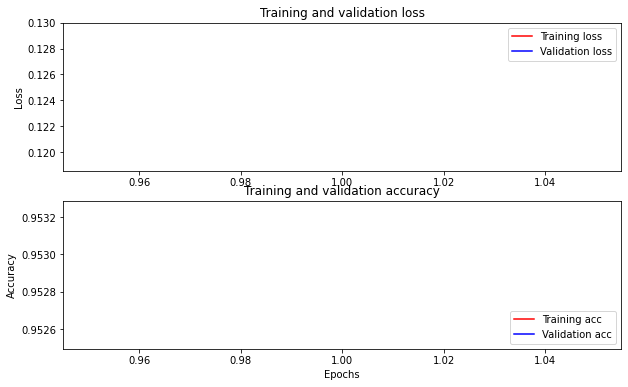

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [23]:
test = pd.read_csv('test_clean.csv')

In [ ]:
test.head()

,id,comment_text,toxicity,target_label
0,7097320,[ Integrity means that you pay your debts.]\n\...,0.0,0
1,7097321,This is malfeasance by the Administrator and t...,0.1,0
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,0.3,0
3,7097323,"Paul: Thank you for your kind words. I do, in...",0.0,0
4,7097324,Sorry you missed high school. Eisenhower sent ...,0.0,0


In [ ]:
#load_classifier_model = tf.keras.models.load_model('/content/drive/My Drive/Capstone/Code/BaseModels/Bert_Keras_Model_1')

In [25]:
classifier_model.evaluate(x = test['comment_text'], y = test['target_label'])  # model_1

3027/3027 [==============================] - 247s 82ms/step - loss: 0.1401 - accuracy: 0.9470 - recall_2: 0.6569


[0.1400555521249771, 0.9470380544662476, 0.6569324135780334]